----------
**Pima Indians Diabetes - EDA & Prediction (0.906)**
=====================================

* **Accuracy - 5 Folds - LightGBM : 89.8%**
* **Accuracy - 5 Folds - LightGBM & KNN : 90.6%**


***Aryaman Pattnayak***

----------

![](http://image.noelshack.com/fichiers/2019/06/1/1549295827-0-0000.png)

- <a href='#1'>1. Load libraries and read the data</a>  

    - <a href='#1.1'>1.1. Load libraries</a> 
    - <a href='#1.2'>1.2. Read the data</a> 
    
- <a href='#2'>2. Overview</a> 

    - <a href='#2.1'>2.1. Head</a> 
    - <a href='#2.2'>2.2. Target</a> 
    - <a href='#2.3'>2.3. Missing values</a> 
    
- <a href='#3'>3. Replace missing values and EDA</a>

    - <a href='#3.1'>3.1. Insulin</a> 
    - <a href='#3.2'>3.2. Glucose</a> 
    - <a href='#3.3'>3.3. SkinThickness</a>
    - <a href='#3.4'>3.4. BloodPressure</a>
    - <a href='#3.5'>3.5. BMI</a>
    
- <a href='#4'>4. New features (16) and EDA</a>

- <a href='#5'>5. Prepare dataset</a> 
    - <a href='#5.1'>5.1. StandardScaler and LabelEncoder</a> 
    - <a href='#5.2'>5.2. Correlation Matrix</a>
    - <a href='#5.3'>5.3. X and y</a>
    - <a href='#5.4'>5.4. Model Performance</a>
	- <a href='#5.4'>5.5. Scores Table</a>
    
- <a href='#6'>6.Machine Learning</a> 

    - <a href='#6.1'>6.1. RandomSearch + LightGBM - Accuracy = 89.8%</a> 
    - <a href='#6.2'>6.2. LightGBM - Discrimination Threshold</a>
    - <a href='#6.3'>6.3. GridSearch + LightGBM & KNN- Accuracy = 90.6%</a>
    - <a href='#6.4'>6.4. LightGBM & KNN - Discrimination Threshold</a>
    
- <a href='#7'>7. Credits</a> 

Hello All !!

This notebook is a guide to end to end a complete study in machine learning with different concepts like :

* Completing missing values (most important part)
* Exploratory data analysis
* Creating new features (to increase accuracy)
* Encoding features
* Using LightGBM and optimize hyperparameters
* Adding a KNN to LGBM to beat 90% accuracy (voting classifier)

# If you like this notebook, feel free to upvote

# Who is Pima Indians ?

"The Pima (or Akimel O'odham, also spelled Akimel O'otham, "River People", formerly known as Pima) are a group of Native Americans living in an area consisting of what is now central and southern Arizona. The majority population of the surviving two bands of the Akimel O'odham are based in two reservations: the Keli Akimel O'otham on the Gila River Indian Community (GRIC) and the On'k Akimel O'odham on the Salt River Pima-Maricopa Indian Community (SRPMIC)." Wikipedia

![](http://image.noelshack.com/fichiers/2019/06/1/1549305367-0-0-0-0-pima.jpg)

# <a id='1'>1. Load libraries and read the data</a> 

## <a id='1.1'>1.1. Load libraries</a> 

Loading the libraries

In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

## <a id='1.2'>1.2. Read data</a> 

Loading dataset with pandas (pd)

In [2]:
data = pd.read_csv('../input/diabetes.csv')

# <a id='2'>2. Overview</a> 

## <a id='2.1'>2.1. Head</a> 

Checking data head and info

In [3]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

Pregnancies  Glucose   ...     Age  Outcome
0            6      148   ...      50        1
1            1       85   ...      31        0
2            8      183   ...      32        1
3            1       89   ...      21        0
4            0      137   ...      33        1

[5 rows x 9 columns]

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

# What is diabetes ? 
Acccording to NIH, "**Diabetes** is a disease that occurs when your blood glucose, also called blood sugar, is too high. Blood glucose is your main source of energy and comes from the food you eat. Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy. Sometimes your body doesn’t make enough—or any—insulin or doesn’t use insulin well. Glucose then stays in your blood and doesn’t reach your cells.

Over time, having too much glucose in your blood can cause health problems. Although diabetes has no cure, you can take steps to manage your diabetes and stay healthy.

Sometimes people call diabetes “a touch of sugar” or “borderline diabetes.” These terms suggest that someone doesn’t really have diabetes or has a less serious case, but every case of diabetes is serious.

**What are the different types of diabetes?**
The most common types of diabetes are type 1, type 2, and gestational diabetes.

**Type 1 diabetes**
If you have type 1 diabetes, your body does not make insulin. Your immune system attacks and destroys the cells in your pancreas that make insulin. Type 1 diabetes is usually diagnosed in children and young adults, although it can appear at any age. People with type 1 diabetes need to take insulin every day to stay alive.

**Type 2 diabetes**
If you have type 2 diabetes, your body does not make or use insulin well. You can develop type 2 diabetes at any age, even during childhood. However, this type of diabetes occurs most often in middle-aged and older people. Type 2 is the most common type of diabetes.

**Gestational diabetes**
Gestational diabetes develops in some women when they are pregnant. Most of the time, this type of diabetes goes away after the baby is born. However, if you’ve had gestational diabetes, you have a greater chance of developing type 2 diabetes later in life. Sometimes diabetes diagnosed during pregnancy is actually type 2 diabetes.

**Other types of diabetes**
Less common types include monogenic diabetes, which is an inherited form of diabetes, and cystic fibrosis-related diabetes ."

## <a id='2.2'>2.2 Target</a> 

What's target's distribution ? 

The above graph shows that the data is unbalanced. The number of non-diabetic is 268 the number of diabetic patients is 500

In [4]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [5]:
target_count()
target_percent()

## <a id='2.3'>2.3. Missing values</a> 

We saw on data.head() that some features contain 0, it doesn't make sense here and this indicates missing value
Below we replace 0 value by NaN :

In [6]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

Now, we can look at where are missing values : 

In [7]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    

In [8]:
# Plotting 
missing_plot(data, 'Outcome')

Missing values : 
* Insulin = 48.7% - 374
* SkinThickness = 29.56% - 227
* BloodPressure = 4.56% - 35
* BMI = 1.43% - 11
* Glucose = 0.65% - 5

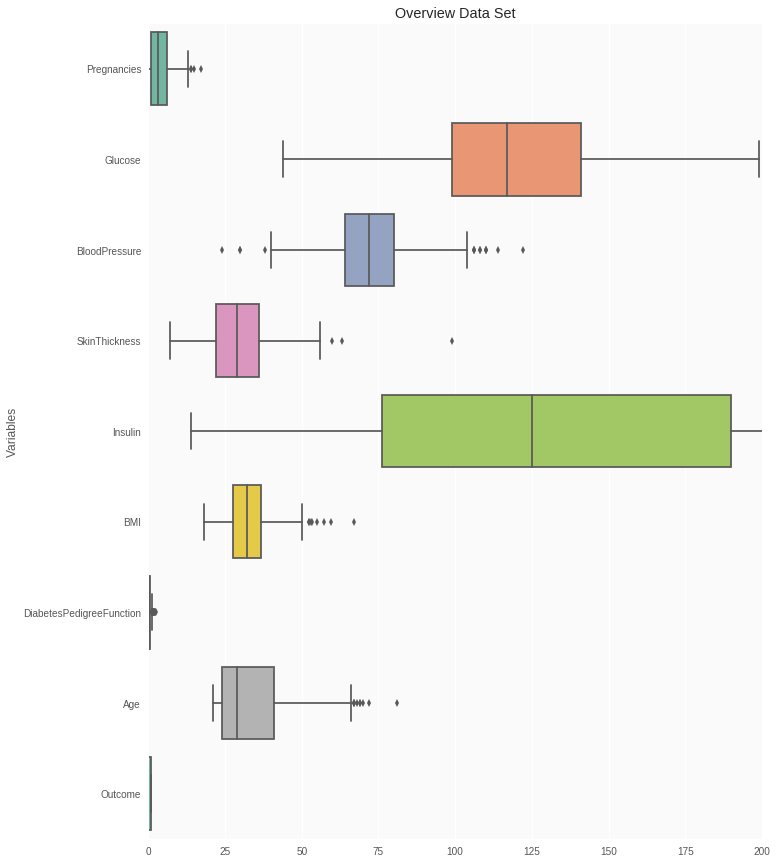

In [9]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

OK, all missing values are encoded with NaN value

**To fill these Nan values the data distribution needs to be understood against the target**. 

In [10]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

A **correlation matrix** is a table showing correlation coefficients between sets of variables. Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). This allows you to see which pairs have the highest correlation.

In [11]:
correlation_plot()


Below, you can see the accuracy of LGBM with replacement of the NaN values by the variable's mean (same results with the median)

![](http://image.noelshack.com/fichiers/2019/06/1/1549276143-0-0-0.png)

To replace missing values, we'll use median by target (Outcome)

# <a id='3'>3. Replace missing values and EDA</a> 

In [12]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

## <a id='3.1'>3.1. Insulin</a> 

* **Insulin** : 2-Hour serum insulin (mu U/ml)

In [13]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [14]:
plot_distribution('Insulin', 0)

In [15]:
median_target('Insulin')

Outcome  Insulin
0        0    102.5
1        1    169.5

Insulin's medians by the target are really different ! 102.5 for a healthy person and 169.5 for a diabetic person

In [16]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

## <a id='3.2'>3.2. Glucose</a> 

* **Glucose** : Plasma glucose concentration a 2 hours in an oral glucose tolerance test

In [17]:
plot_distribution('Glucose', 0)

In [18]:
median_target('Glucose')

Outcome  Glucose
0        0    107.0
1        1    140.0

In [19]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

107 for a healthy person and 140 for a diabetic person

## <a id='3.3'>3.3. SkinThickness</a> 

* ** SkinThickness** : Triceps skin fold thickness (mm)

In [20]:
plot_distribution('SkinThickness', 10)

In [21]:
median_target('SkinThickness')

Outcome  SkinThickness
0        0           27.0
1        1           32.0

In [22]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

27 for a healthy person and 32 for a diabetic person

## <a id='3.4'>3.4. BloodPressure</a> 

* ** BloodPressure** : Diastolic blood pressure (mm Hg)

In [23]:
plot_distribution('BloodPressure', 5)

In [24]:
median_target('BloodPressure')

Outcome  BloodPressure
0        0           70.0
1        1           74.5

In [25]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

## <a id='3.5'>3.5. BMI</a> 

* **BMI** : Body mass index (weight in kg/(height in m)^2)

In [26]:
plot_distribution('BMI', 0)

In [27]:
median_target('BMI')

Outcome   BMI
0        0  30.1
1        1  34.3

In [28]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

* **Age** : Age (years)
* **DiabetesPedigreeFunction** : Diabetes pedigree function
* **Pregnancies** : Number of times pregnant

In [29]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [30]:
missing_plot(data, 'Outcome')

All features are complete ! 
Now, we can create new features

# <a id='4'>4. New features (16) and EDA</a> 

Here, we define 3 plots functions

In [31]:
def plot_feat1_feat2(feat1, feat2) :  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [32]:
def barplot(var_select, sub) :
    tmp1 = data[(data['Outcome'] != 0)]
    tmp2 = data[(data['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [33]:
# Define pie plot to visualize each variable repartition vs target modalities : Survived or Died (train)
def plot_pie(var_select, sub) :
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    
    col =['Silver', 'mediumturquoise','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = H[var_select].value_counts().values.tolist(),
                    labels  = H[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Healthy" )

    layout = go.Layout(dict(title = var_select + " distribution by target <br>"+(sub),
                            annotations = [ dict(text = "Diabetic"+" : "+"268",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Healthy"+" : "+"500",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

* **Glucose and Age**

In [34]:
plot_feat1_feat2('Glucose','Age')

Healthy persons are concentrate with an age <= 30 and glucose <= 120

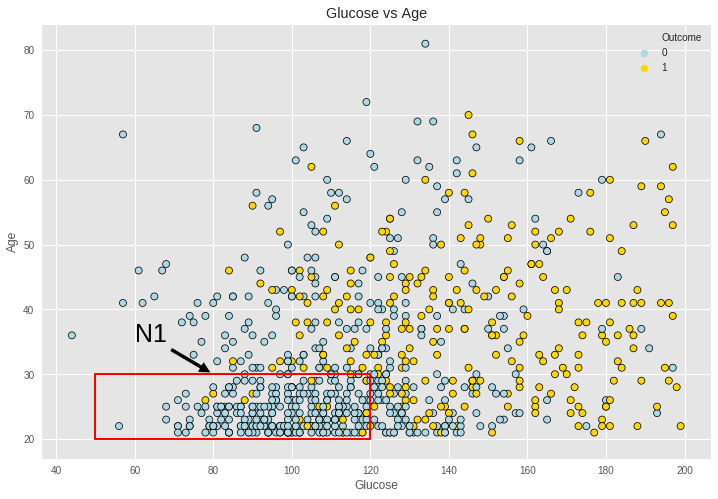

In [35]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(80, 30), xytext=(60, 35),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([50, 120], [30, 30], linewidth=2, color = 'red')
plt.plot([120, 120], [20, 30], linewidth=2, color = 'red')
plt.plot([50, 120], [20, 20], linewidth=2, color = 'red')
plt.plot([50, 50], [20, 30], linewidth=2, color = 'red')
plt.title('Glucose vs Age')
plt.show()

In [36]:
data.loc[:,'N1']=0
data.loc[(data['Age']<=30) & (data['Glucose']<=120),'N1']=1

In [37]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

In [38]:
plot_pie('N1', '(Glucose <= 120 and Age <= 30)')

* **BMI **

According to wikipedia "The body mass index (BMI) or Quetelet index is a value derived from the mass (weight) and height of an individual. The BMI is defined as the body mass divided by the square of the body height, and is universally expressed in units of kg/m2, resulting from mass in kilograms and height in metres."

30 kg/m² is the limit to obesity

In [39]:
data.loc[:,'N2']=0
data.loc[(data['BMI']<=30),'N2']=1

In [40]:
barplot('N2', ': BMI <= 30')

In [41]:
plot_pie('N2', 'BMI <= 30')

* **Pregnancies and Age**

In [42]:
plot_feat1_feat2('Pregnancies','Age')

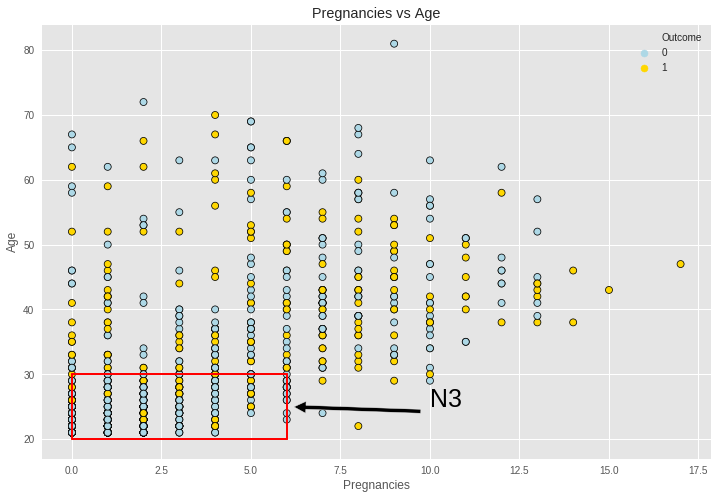

In [43]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Pregnancies'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N3', size=25, color='black', xy=(6, 25), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 6], [30, 30], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 30], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 30], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

In [44]:
data.loc[:,'N3']=0
data.loc[(data['Age']<=30) & (data['Pregnancies']<=6),'N3']=1

In [45]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

In [46]:
plot_pie('N3', 'Age <= 30 and Pregnancies <= 6')

* **Glucose and BloodPressure**

In [47]:
plot_feat1_feat2('Glucose','BloodPressure')

Healthy persons are concentrate with an blood pressure <= 80 and glucose <= 105

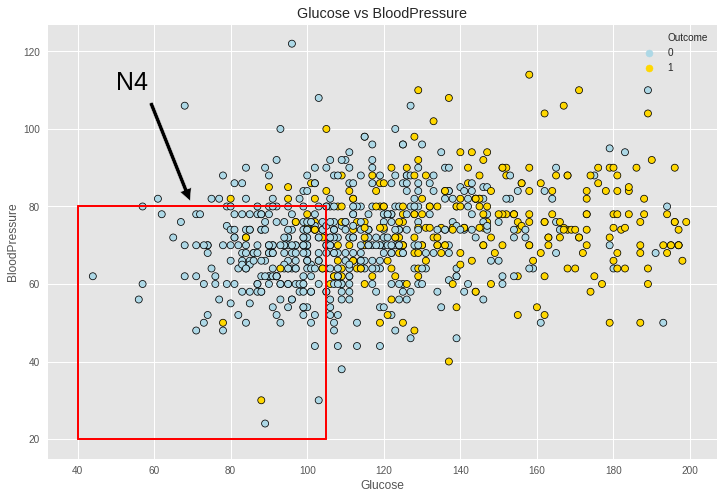

In [48]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BloodPressure'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(70, 80), xytext=(50, 110),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([40, 105], [80, 80], linewidth=2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth=2, color = 'red')
plt.plot([40, 105], [20, 20], linewidth=2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth=2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

In [49]:
data.loc[:,'N4']=0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80),'N4']=1

In [50]:
barplot('N4', ': Glucose <= 105 and BloodPressure <= 80')

In [51]:
plot_pie('N4', 'Glucose <= 105 and BloodPressure <= 80')

* **SkinThickness**

In [52]:
data.loc[:,'N5']=0
data.loc[(data['SkinThickness']<=20) ,'N5']=1

In [53]:
barplot('N5', ':SkinThickness <= 20')

In [54]:
plot_pie('N5', 'SkinThickness <= 20')

* **SkinThickness and BMI**

In [55]:
plot_feat1_feat2('SkinThickness','BMI')

Healthy persons are concentrate with a BMI < 30 and skin thickness <= 20

In [56]:
data.loc[:,'N6']=0
data.loc[(data['BMI']<30) & (data['SkinThickness']<=20),'N6']=1

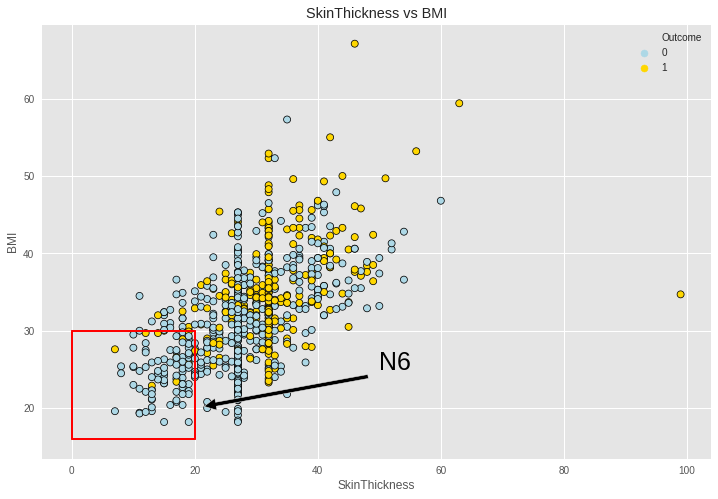

In [57]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['SkinThickness'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N6', size=25, color='black', xy=(20, 20), xytext=(50, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 20], [30, 30], linewidth=2, color = 'red')
plt.plot([0, 0], [16, 30], linewidth=2, color = 'red')
plt.plot([0, 20], [16, 16], linewidth=2, color = 'red')
plt.plot([20, 20], [16, 30], linewidth=2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()

In [58]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

In [59]:
plot_pie('N6', 'BMI < 30 and SkinThickness <= 20')

* **Glucose and BMI**

In [60]:
plot_feat1_feat2('Glucose','BMI')

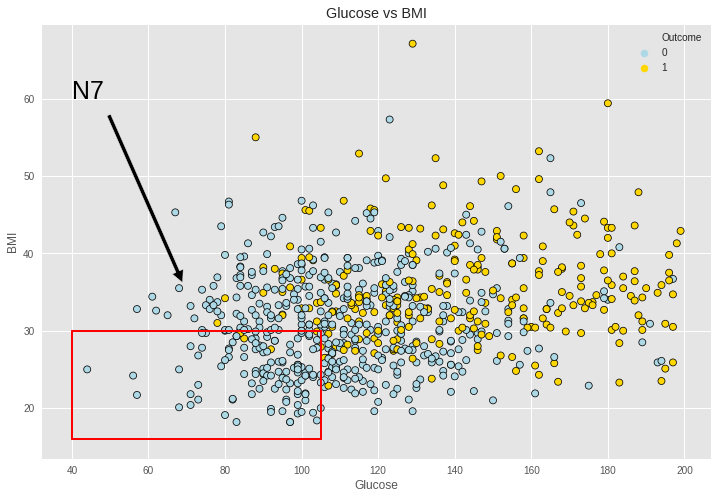

In [61]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N7', size=25, color='black', xy=(70, 35), xytext=(40, 60),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([105, 105], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 40], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 105], [16, 16], linewidth=2, color = 'red')
plt.plot([40, 105], [30, 30], linewidth=2, color = 'red')
plt.title('Glucose vs BMI')
plt.show()

In [62]:
data.loc[:,'N7']=0
data.loc[(data['Glucose']<=105) & (data['BMI']<=30),'N7']=1

In [63]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

In [64]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

* **Insulin**

In [65]:
plot_distribution('Insulin', 0)

In [66]:
data.loc[:,'N9']=0
data.loc[(data['Insulin']<200),'N9']=1

In [67]:
barplot('N9', ': Insulin < 200')

In [68]:
plot_pie('N9', 'Insulin < 200')

* **BloodPressure**

In [69]:
data.loc[:,'N10']=0
data.loc[(data['BloodPressure']<80),'N10']=1

In [70]:
barplot('N10', ': BloodPressure < 80')

In [71]:
plot_pie('N10', 'BloodPressure < 80')

* **Pregnancies**

In [72]:
plot_distribution('Pregnancies', 0)

In [73]:
data.loc[:,'N11']=0
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']=1

In [74]:
barplot('N11', ': Pregnancies > 0 and < 4')

In [75]:
plot_pie('N11', 'Pregnancies > 0 and < 4')

* **Others**

In [76]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] =  data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']


In [77]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

* ** Did you watch Inception ? ** Here is the same! It's not a dream in a dream but a new feature extract from a new feature

In [78]:
plot_distribution('N0', 0)

In [79]:
data.loc[:,'N15']=0
data.loc[(data['N0']<1034) ,'N15']=1

In [80]:
barplot('N15', ': N0 < 1034')

In [81]:
plot_pie('N15', 'N0 < 1034')

# <a id='5'>5. Prepare dataset</a> 

## <a id='5.1'>5.1. StandardScaler and LabelEncoder</a> 

* ** StandardScaler** :

Standardize features by removing the mean and scaling to unit variance : 

![](http://image.noelshack.com/fichiers/2019/06/1/1549282952-0-0-0-0-0-0.png)

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

* ** LabelEncoder** : Encode labels with value between 0 and n_classes-1.

Bellow we encode the data to feed properly to our algorithm

In [82]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

Now, we can compute correlation matrix 

## <a id='5.2'>5.2. Correlation Matrix</a> 

A **correlation matrix** is a table showing correlation coefficients between sets of variables. Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). This allows you to see which pairs have the highest correlation.

In [83]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)


In [84]:
correlation_plot()

## <a id='5.3'>5.3. X and y</a> 

We define X and y :

In [85]:
# Def X and Y
X = data.drop('Outcome', 1)
y = data['Outcome']

## <a id='5.4'>5.4. Model Performance</a> 

To measure the performance of a model, we need several elements :

This part is essential

* **Confusion matrix** : also known as the error matrix, allows visualization of the performance of an algorithm :

    * true positive (TP) : Diabetic correctly identified as diabetic
    * true negative (TN) : Healthy correctly identified as healthy
    * false positive (FP) : Healthy incorrectly identified as diabetic
    * false negative (FN) : Diabetic incorrectly identified as healthy

![](https://image.noelshack.com/fichiers/2018/20/5/1526651914-cs-heezweaa5hp7.jpg)

* **Metrics ** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP)
    * Recall : TP / (TP + FN)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall))

* **Roc Curve** : The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

![](http://image.noelshack.com/fichiers/2019/06/1/1549284841-0-0-0-0-0-0-0-0-0-0.png)

* **Precision Recall Curve** :  shows the tradeoff between precision and recall for different threshold

To train and test our algorithm we'll use cross validation K-Fold

![](http://image.noelshack.com/fichiers/2019/06/1/1549288372-00001.png)

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once.

Bellow we define a stylized report with Plotly

In [86]:
def model_performance(model, subtitle) :   
    #Kfold
    cv = KFold(n_splits=5,shuffle=False, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

## <a id='5.5'>5.5. Scores Tables</a> 

We can complete model performance report with a table contain all results by fold

In [87]:
def scores_table(model, subtitle):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename = 'styled_table')

# <a id='6'>6. Machine Learning</a> 

## <a id='6.1'>6.1. RandomSearch + LightGBM - Accuracy = 89.8%</a> 

![](http://image.noelshack.com/fichiers/2019/06/1/1549285917-0000000000000000000.png)

** LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

To find the best hyperparameters, we'll use Random Search CV.

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. 
Generally RS is more faster and accurate than GridSearchCV who calculate all possible combinations. With Random Grid we specify the number of combinations that we want

* **LightGBM : Hyperparameters ** :

    * learning_rate : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates
    * n_estimators : number of trees (or rounds)
    * num_leaves : number of leaves in full tree, default: 31
    * min_child_samples : minimal number of data in one leaf. Can be used to deal with over-fitting
    * min_child_weight : minimal sum hessian in one leaf.
    * subsample : randomly select part of data without resampling
    * max_depth : It describes the maximum depth of tree. This parameter is used to handle model overfitting.
    * colsample_bytree : LightGBM will randomly select part of features on each iteration if colsample_bytree smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
    * reg_alpha : regularization
    * reg_lambda : regularization
    
    * early_stopping_rounds : This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations

In [88]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  2.2min finished


In [89]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

## <a id='6.2'>6.2. LightGBM - Discrimination Threshold</a> 

* **Discrimination Threshold** :
A visualization of precision, recall, f1 score, and queue rate with respect to the discrimination threshold of a binary classifier. The discrimination threshold is the probability or score at which the positive class is chosen over the negative class

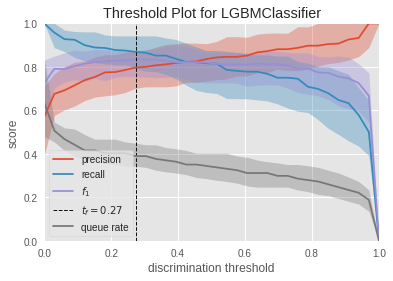

In [90]:
visualizer = DiscriminationThreshold(lgbm_clf)

visualizer.fit(X, y)  
visualizer.poof() 

## <a id='6.3'>6.3. GridSearch + LightGBM & KNN- Accuracy = 90.6%</a> 

We obtain a really good result but we can beat 90% with adding a KNeighborsClassifier to LightGBM (Voting Classifier)

* **KNeighborsClassifier** : KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, where  k is an integer value specified by the user.

* **VotingClassifier** : VotingClassifier is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting

With GridSearch CV we search the best "n_neighbors" to optimize accuracy of Voting Classifier

In [91]:
knn_clf = KNeighborsClassifier()

voting_clf = VotingClassifier(estimators=[ 
    ('lgbm_clf', lgbm_clf),
    ('knn', KNeighborsClassifier())], voting='soft', weights = [1,1])

params = {
      'knn__n_neighbors': np.arange(1,30)
      }
      
grid = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)

grid.fit(X,y)

print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.90625
Best Parameters: {'knn__n_neighbors': 25}


With n_neighbors = 25, the accuracy increase to 90.625 ! Bellow the model performance report 

In [92]:
knn_clf = KNeighborsClassifier(n_neighbors = 25)

voting_clf = VotingClassifier (
        estimators = [('knn', knn_clf), ('lgbm', lgbm_clf)],
                     voting='soft', weights = [1,1])

In [93]:
model_performance(voting_clf, 'LightGBM & KNN')
scores_table(voting_clf, 'LightGBM & KNN')

## <a id='6.4'>6.4. LightGBM & KNN  - Discrimination Threshold</a> 

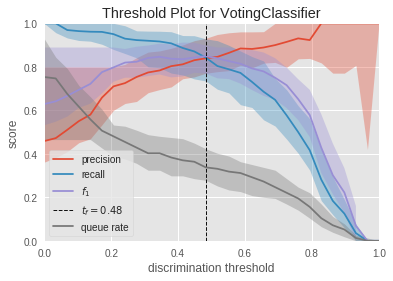

In [94]:
visualizer = DiscriminationThreshold(voting_clf)

visualizer.fit(X, y)  
visualizer.poof()  

# <a id='7'>7. Credits</a> 

Credits  : 
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
* https://en.wikipedia.org/wiki/Body_mass_index
* http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/
* https://www.news-medical.net/health/What-is-Diabetes.aspx
* https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
* http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://www.scikit-yb.org/en/latest/api/classifier/threshold.html
* https://www.analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
* https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://twitter.com/bearda24
* https://www.slideshare.net/DhianaDevaRocha/qcon-rio-machine-learning-for-everyone
* https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0
* https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes
* https://en.wikipedia.org/wiki/Pima_people

## Thank you all ! Merci à tous ! :)